# Marginalizing over Discretes

##### Keywords: marginalizing over discretes, mixture model, gaussian mixture model, log-sum-exp trick, pymc3

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
import theano.tensor as tt

//anaconda/envs/py3l/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We'll first load the tightly coupled gaussian data from the notebook where we did the non-marginalized sampling.

In [2]:
data=np.loadtxt("data/3gv2.dat")
data.shape

(100,)

### The choice of a prior

The Dirichlet is the multi-dimensional analog of the Beta. Higher values force you to be more central. 

## The log-sum-exp trick and mixtures

From the Stan Manual:

>The log sum of exponentials function is used to define mixtures on the log scale. It is defined for two inputs by

$$log\_sum\_exp(a, b) = log(exp(a) + exp(b)).$$

>If a and b are probabilities on the log scale, then $exp(a) + exp(b)$ is their sum on the linear scale, and the outer log converts the result back to the log scale; to summarize, log_sum_exp does linear addition on the log scale. The reason to use the built-in log_sum_exp function is that it can prevent underflow and overflow in the exponentiation, by calculating the result as

$$log \left( exp(a) + exp(b) \right)  = c + log  exp(a − c) + exp(b − c)  ,$$

>where c = max(a, b). In this evaluation, one of the terms, a − c or b − c, is zero and the other is negative, thus eliminating the possibility of overflow or underflow in the leading term and eking the most arithmetic precision possible out of the operation.

As one can see below, `pymc3` uses the same definition

From https://github.com/pymc-devs/pymc3/blob/master/pymc3/math.py#L27

```python
def logsumexp(x, axis=None):
    # Adapted from https://github.com/Theano/Theano/issues/1563
    x_max = tt.max(x, axis=axis, keepdims=True)
    return tt.log(tt.sum(tt.exp(x - x_max), axis=axis, keepdims=True)) + x_max
```

For example (as taken from the Stan Manual), the mixture of $N(−1, 2)$ and $N(3, 1)$ with mixing proportion $\lambda = (0.3, 0.7)$:

$$logp(y \vert \lambda, \mu, \sigma)$$

$$= log\left(0.3×N(y \vert −1,2) + 0.7×N(y \vert 3,1)\right)$$

$$= log\left(exp(log(0.3 × N(y \vert − 1, 2)))  + exp(log(0.7 × N(y \vert 3, 1))) \right)$$

$$= \mathtt{log\_sum\_exp}\left(log(0.3) + log\,N(y \vert − 1, 2), log(0.7) + log\, N(y \vert 3, 1) \right).$$

where `log_sum_exp` is the function as defined above.

This generalizes to the case of more mixture components.

This is thus a custon distribution `logp` we must define. If we do this, we can go directly from the Dirichlet priors for $p$ and forget the `category` variable

## Pymc3 implements the log-sum-exp directly

Lets see the source here to see how its done:

https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/mixture.py

There is a marginalized Gaussian Mixture model available, as well as a general mixture. We'll use the `NormalMixture`, to which we must provide mixing weights and components.

In [7]:
import pymc3.distributions.transforms as tr
with pm.Model() as mof3:
    p = pm.Dirichlet('p', a=np.array([10., 10., 10.]), shape=3)
    means = pm.Normal('means', mu=0, sd=10, shape=3, transform=tr.ordered,
                  testval=np.array([-1, 0, 1]))


    points = pm.NormalMixture('obs', p, mu=means, sd=1, observed=data)


In [24]:
with mof3:
    tripletrace_full3 = pm.sample(10000, tune=2000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [means, p]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:34<00:00, 253.32draws/s]
The number of effective samples is smaller than 25% for some parameters.


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


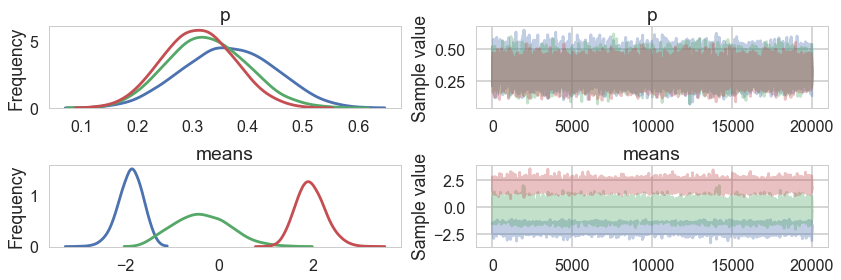

In [26]:
pm.traceplot(tripletrace_full3, combined=True);

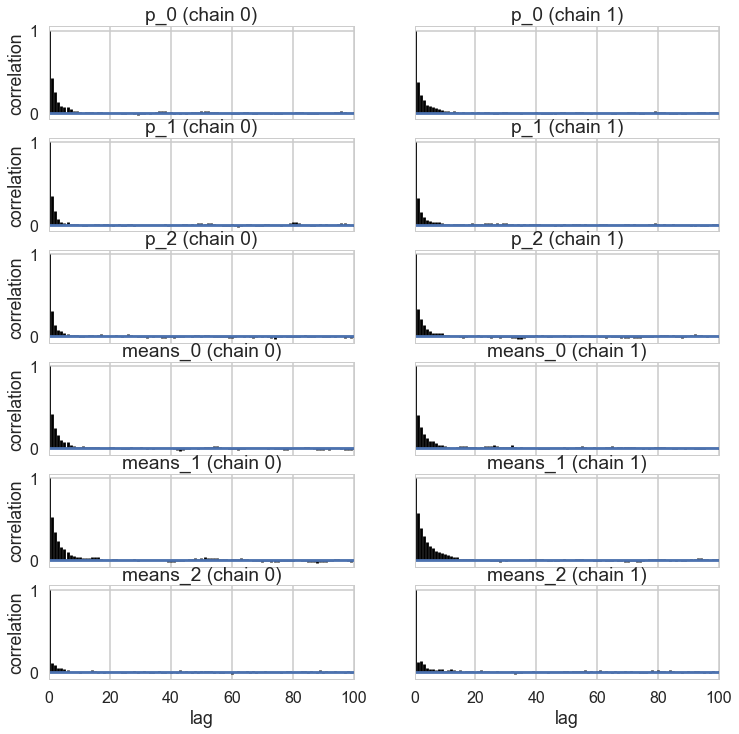

In [27]:
pm.autocorrplot(tripletrace_full3);

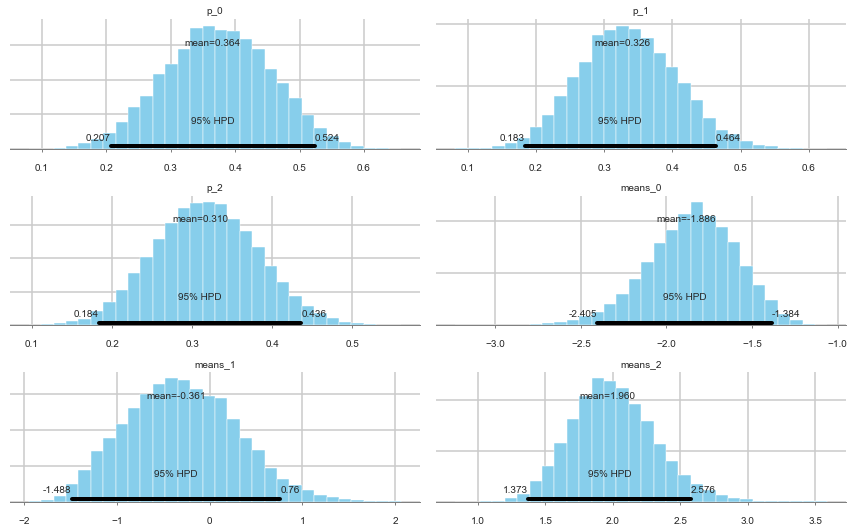

In [28]:
pm.plot_posterior(tripletrace_full3);

Ordered, even with Dirichlets, our model fits quite nicely.

## Posterior Predictive

In [29]:
with mof3:
    ppc_trace = pm.sample_ppc(tripletrace_full3, 5000)

100%|██████████| 5000/5000 [00:10<00:00, 479.60it/s]


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


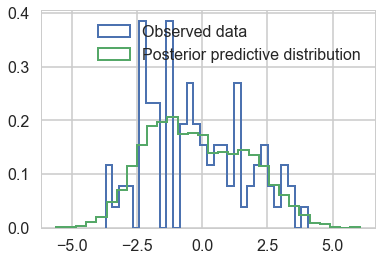

In [31]:
plt.hist(data, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
plt.hist(ppc_trace['obs'][:,0], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

plt.legend(loc=1);

You can see the general agreement between these two distributions in this posterior predictive check!

## Marginalizing By Hand

We need to write out the `logp` for the likelihood ourself now, using `logsumexp` to do the sum we need.

In [38]:
from pymc3.math import logsumexp


def logp_normal(mu, sigma, value):
    # log probability of individual samples
    delta = lambda mu: value - mu
    return (-1 / 2.) * (tt.log(2 * np.pi) + tt.log(sigma*sigma) +
                         (delta(mu)* delta(mu))/(sigma*sigma))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pis, sigmas, n_samples, n_components):
                        
    def logp_(value):        
        logps = [tt.log(pis[i]) + logp_normal(means[i], sigmas[i], value)
                 for i in range(n_components)]
            
        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

In [39]:
with pm.Model() as mof2:
    p = pm.Dirichlet('p', a=np.array([10., 10., 10.]), shape=3)

    # cluster centers
    means = pm.Normal('means', mu=0, sd=10, shape=3, transform=tr.ordered,
                  testval=np.array([-1, 0, 1]))


    sds = [1., 1., 1.]


    # likelihood for each observed valueDensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)
    points = pm.DensityDist('obs', logp_gmix(means, p, sds, data.shape[0], 3),
                       observed=data)

In [40]:
with mof2:
    tripletrace_full2 = pm.sample(10000, tune=2000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [means, p]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:58<00:00, 202.33draws/s]
The number of effective samples is smaller than 25% for some parameters.


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


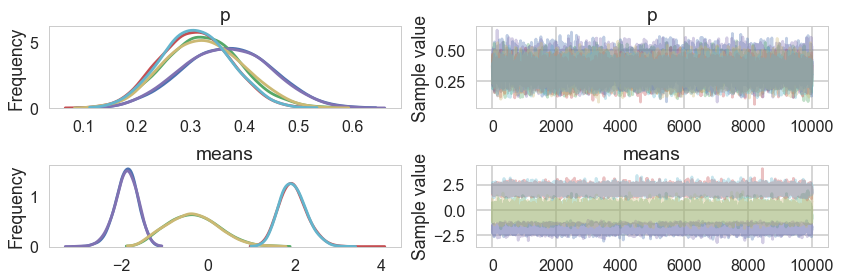

In [41]:
pm.traceplot(tripletrace_full2);

### Posterior predictive

You cant use `sample_ppc` directly because we did not create a sampling function for our DensityDist. But this is easy to do for a mixture model. Sample a categorical from the p's above, and then sample the appropriate gaussian.

>Exercise: Write a function to do this!

In [45]:
with mof2:
    ppc_trace2 = pm.sample_ppc(tripletrace_full2, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

ValueError: Distribution was not passed any random method Define a custom random method and pass it as kwarg random

## ADVI

ADVI also needs a marginalized model as it uses gradient descent.

In [11]:
mdvar = pm.ADVI(model=mof3)
mdvar.fit(n=15000)

Average Loss = 213.02: 100%|██████████| 15000/15000 [00:13<00:00, 1081.19it/s]
Finished [100%]: Average Loss = 213.02


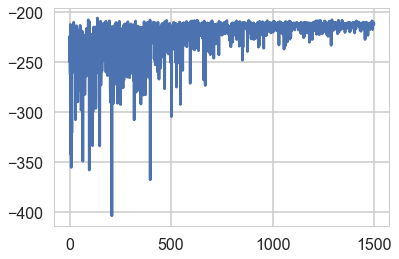

In [13]:
plt.plot(-mdvar.hist[::10])

In [14]:
samps=mdvar.approx.sample(5000)

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


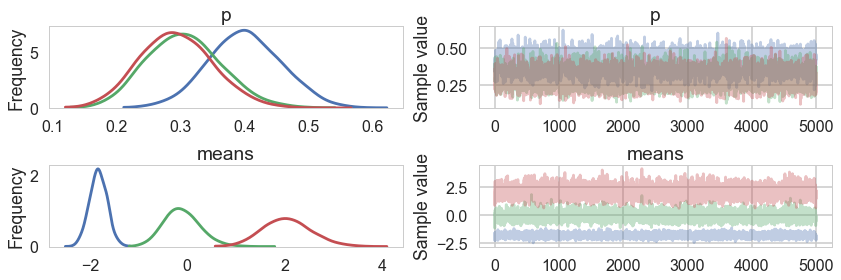

In [15]:
pm.traceplot(samps);

In [16]:
pred = pm.sample_ppc(samps, 5000, model=mof3)

100%|██████████| 5000/5000 [00:10<00:00, 463.14it/s]


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


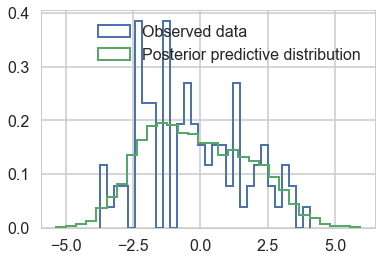

In [18]:
plt.hist(data, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
plt.hist(pred['obs'][:,0], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

plt.legend(loc=1);

We do quite well!

## A much more separated gaussian model

In [20]:
data2=np.loadtxt("data/3g.dat")

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


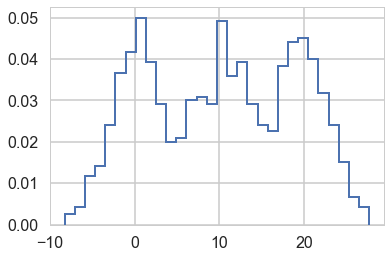

In [21]:
plt.hist(data2, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');

Notice below the use of Potentials. These ensure that there are (a) some members in each cluster and (b) provide us a fifferent way to specify the ordering. This works aby adding log-probability to a model to prevent the sampler going to places where this is negative infinity.

In [24]:
## Class Model for 3 gaussian mixture

with pm.Model() as mofsep:
    p = pm.Dirichlet('p', a=np.array([2., 2., 2.]), shape=3)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))

    # cluster centers
    means = pm.Normal('means', mu=[0, 10, 20], sd=5, shape=3)

    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))
                                         
    # measurement error
    sds = pm.HalfCauchy('sds', beta=5, shape=3)


    # likelihood for each observed value
    points = pm.NormalMixture('obs', p, mu=means, sd=sds, observed=data2)



In [25]:
with mofsep:
    tracesep_full = pm.sample(10000, tune=2000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sds, means, p]
Sampling 2 chains: 100%|██████████| 24000/24000 [02:09<00:00, 184.97draws/s]


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


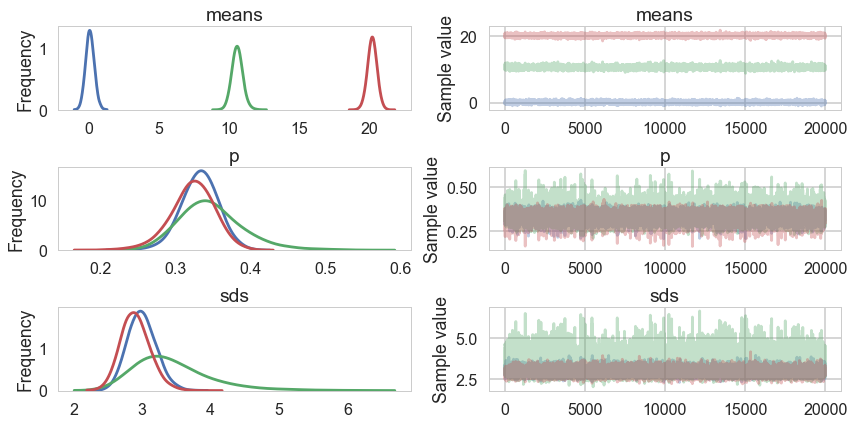

In [26]:
pm.traceplot(tracesep_full, combined=True);

In [28]:
with mofsep:
    ppc_tracesep = pm.sample_ppc(tracesep_full, 5000)

100%|██████████| 5000/5000 [00:13<00:00, 376.18it/s]


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


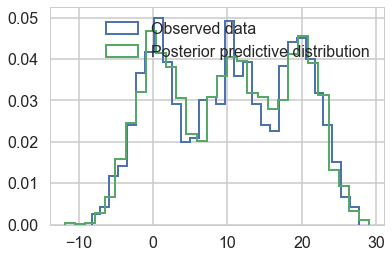

In [29]:
plt.hist(data2, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
plt.hist(ppc_tracesep['obs'][:,0], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

plt.legend(loc=1);

This samples very cleanly and we can do ADVI as well...

In [30]:
mdvarsep = pm.ADVI(model=mofsep)
mdvarsep.fit(n=15000)

Average Loss = 3,475.3: 100%|██████████| 15000/15000 [00:19<00:00, 779.49it/s]
Finished [100%]: Average Loss = 3,475.3


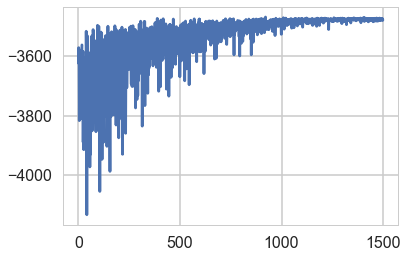

In [31]:
plt.plot(-mdvarsep.hist[::10])

In [32]:
sampssep=mdvarsep.approx.sample(5000)

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


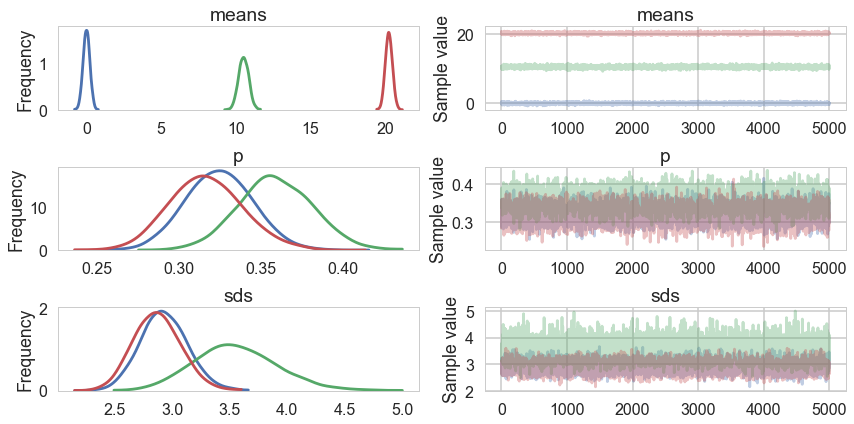

In [33]:
pm.traceplot(sampssep);

In [35]:
predsep = pm.sample_ppc(sampssep, 5000, model=mofsep)

100%|██████████| 5000/5000 [00:11<00:00, 440.11it/s]


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


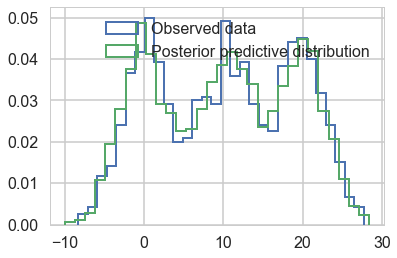

In [36]:
plt.hist(data2, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
plt.hist(predsep['obs'][:,0], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

plt.legend(loc=1);